## **Load *Monod*+meK-Means and Packages**

In [1]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [5]:
#Test with controls for now, and remove later if necessary 

In [6]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')
meta.head()

cell_barcode                    guide_identity  read_count  \
0  TTGAACGAGACTCGGA-2  ARID1A_NegCtrl0__ARID1A_NegCtrl0       28684   
1  CGTTGGGGTGTTTGTG-7  BCORL1_NegCtrl0__BCORL1_NegCtrl0       18367   
2  GAACCTAAGTGTTAGA-6      FOSB_NegCtrl0__FOSB_NegCtrl0       16296   
3  CCTTCCCTCCGTCATC-4                SET_KLF1__SET_KLF1       16262   
4  TCAATCTGTCTTTCAT-2      OSR2_NegCtrl0__OSR2_NegCtrl0       16057   

   UMI_count   coverage  gemgroup  good_coverage  number_of_cells  
0       1809  15.856274         2           True                1  
1        896  20.498884         7           True                1  
2        664  24.542169         6           True                1  
3        850  19.131765         4           True                1  
4       1067  15.048735         2           True                2

In [7]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts
saveCounts.head()

guide_identity  cells
0  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0   3532
1    NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0   2948
2  NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0   2839
3    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0   2536
4            CEBPE_RUNX1T1__CEBPE_RUNX1T1   1219

Filter for conditions with > 100 cells (since we're looking for possible subpopulations/states etc)

In [8]:
filt_ids = list(saveCounts['guide_identity'][saveCounts['cells'] >  100])
len(filt_ids)

273

**For all pair conditions, find matching single conds and extract important genes**

In [9]:
import random

In [10]:
def input_for_sel(S1,S2,SC):
    '''
    Take in S counts for cond11,2,and control
    Normalize/scale S counts for test/train data for classifier
    Output normalized data (only for cond1/2 and control)
    '''
    
    X1 = S1 #cellxgene
    X2 = S2

    X_ctrl = SC
    
    min_size = np.min([X1.shape[0],X2.shape[0],X_ctrl.shape[0]])
    sub_inds = [] 
    for x in [X1,X2,X_ctrl]:
         sub_inds += [random.sample(range(x.shape[0]),min_size)] #Keep equal sized samples
            
    #sub_inds = random.sample(range(X_ctrl.shape[0]),X2.shape[0])
    X1 = X1[sub_inds[0],:]
    X2 = X2[sub_inds[1],:]
    X_ctrl = X_ctrl[sub_inds[2],:]

    X_conds = np.concatenate((X1,X2),axis=0) #X_both


    Y_conds = ['Cond1']*X1.shape[0]+['Cond2']*X2.shape[0] #+[dataset_names[inds[2]]]*X_both.shape[0]
    Y_conds_ctrl = Y_conds + ['Ctrl']*X_ctrl.shape[0]

    Y_conds = np.array(Y_conds)
    Y_conds_ctrl = np.array(Y_conds_ctrl)

    #dataset_names[i]

    #Scale cell reads, * median_reads/reads
    condTot = np.sum(X_conds,axis=1)
    median = np.median(condTot)
    ctrlTot = np.sum(X_ctrl,axis=1)
    facts = median/condTot
    factsCtrl = median/ctrlTot


    X_conds_norm = X_conds*np.repeat(facts.reshape(-1, 1), X_conds.shape[1], 1)
    X_ctrl_norm = X_ctrl*np.repeat(factsCtrl.reshape(-1, 1), X_ctrl.shape[1], 1)

    #Scale controls to same median
    X_conds_ctrl_norm = np.concatenate((X_conds_norm,X_ctrl_norm),axis=0)

    #From each cond, subtract ctrl mean and /std dev (Z-normalization)
    ctrl_mu = np.mean(X_ctrl_norm,axis=0) #For each gene
    ctrl_std = np.std(X_ctrl_norm,axis=0)


    X_conds_norm = (X_conds_norm-ctrl_mu)/(ctrl_std+1e-4) #Can lead to divide by zeros
    X_conds_ctrl_norm = (X_conds_ctrl_norm-ctrl_mu)/(ctrl_std+1e-4)
    
    return X_conds_ctrl_norm, Y_conds_ctrl


In [11]:
def sel_genes(X_conds_ctrl_norm ,Y_conds_ctrl, test_size=0.2,n_jobs = 10,num_features = 100):
    '''
    Take in scaled counts for cond1/2, & control,.
    Split data into test/train for classifier and extract top predictive genes.
    Output top genes for prediction condition label.
    '''
    
    test_size = test_size
    n_jobs = n_jobs

    X = X_conds_ctrl_norm 
    Y = Y_conds_ctrl

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)

    #From https://github.com/thomasmaxwellnorman/Perturbseq_GI/blob/3b25109aeb9c0c2026bd70abd50304a0ad4e5395/perturbseq/differential_expression.py#L213
    f_repr = 100
    # n_feat * 2 because the training matrix is extended with n shadow features
    multi = ((X_train.shape[1] * 2) / (np.sqrt(X_train.shape[1] * 2) * 10))
    n_estimators = int(multi * f_repr)
    #print('n_estimators: ',n_estimators)

    #.fit()
    clf_tree = ExtraTreesClassifier(n_jobs=n_jobs, n_estimators=n_estimators, class_weight='balanced', random_state=42)
    clf_tree.fit(X_train, Y_train)

    #.predict() on X_test
    Y_pred = clf_tree.predict(X_test)

    #get accuracy_score and classification_report
    acc = accuracy_score(Y_test, Y_pred)
    print('Feature prediction accuracy (test size: {1:.1f}%): {0}\n'.format(acc, 100*test_size))
    
    print('Unpredicted labels: ', set(Y_test) - set(Y_pred))
   
    
    report = classification_report(Y_test, Y_pred)
    #print(report)


    #get feature_importances
    num_features = num_features #Top 100 genes for now

    idx = np.argsort(clf_tree.feature_importances_)[::-1]
    gene_indices = idx[0:num_features]
    top_gene_names = g_names_2[gene_indices]
    
    plt.scatter(range(len(idx)),clf_tree.feature_importances_[idx])
    plt.vlines(f_repr,np.min(clf_tree.feature_importances_[idx]),np.max(clf_tree.feature_importances_[idx]))
    
    return top_gene_names


In [12]:
#Not 'Neg' paired conds
notNeg = [f for f in filt_ids if 'Neg' not in f]

In [13]:
first = [i.split('_')[0] for i in notNeg]
secnd = [i.split('_')[1] for i in notNeg]

all_targets = np.unique(first+secnd)

In [14]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/norman_crispr/loom/allcrispr.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [19]:
#Select genes to begin with that have enough U/S counts
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    }

expr_filt = monod.preprocess.threshold_by_expression(S.T,U.T,filt_param)

In [20]:
g_names_2 = g_names[expr_filt]

In [21]:
np.sum(expr_filt)

5802

In [22]:
ctrl_bars = list(meta.cell_barcode[meta.guide_identity.isin(['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0',
                                                             'NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
          'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0'])])

ctrl_S = S[np.isin(bars,ctrl_bars),:]

In [23]:
ctrl_S = ctrl_S[:,expr_filt] 
ctrl_S.shape

(8907, 5802)

0
Feature prediction accuracy (test size: 20.0%): 0.6581196581196581

Unpredicted labels:  set()
1
Feature prediction accuracy (test size: 20.0%): 0.678743961352657

Unpredicted labels:  set()
2
Feature prediction accuracy (test size: 20.0%): 0.7995642701525054

Unpredicted labels:  set()
3
Feature prediction accuracy (test size: 20.0%): 0.6993355481727574

Unpredicted labels:  set()
4
Feature prediction accuracy (test size: 20.0%): 0.785876993166287

Unpredicted labels:  set()
5
Feature prediction accuracy (test size: 20.0%): 0.8496621621621622

Unpredicted labels:  set()
6
Feature prediction accuracy (test size: 20.0%): 0.8293918918918919

Unpredicted labels:  set()
7
Feature prediction accuracy (test size: 20.0%): 0.5822222222222222

Unpredicted labels:  set()
8
Feature prediction accuracy (test size: 20.0%): 0.5720164609053497

Unpredicted labels:  set()
9
Feature prediction accuracy (test size: 20.0%): 0.7251908396946565

Unpredicted labels:  set()
10
Feature prediction accuracy (

85
Feature prediction accuracy (test size: 20.0%): 0.6282051282051282

Unpredicted labels:  set()
86
Feature prediction accuracy (test size: 20.0%): 0.5217391304347826

Unpredicted labels:  set()
87
Feature prediction accuracy (test size: 20.0%): 0.7935323383084577

Unpredicted labels:  set()
88
Feature prediction accuracy (test size: 20.0%): 0.7450980392156863

Unpredicted labels:  set()
89
Feature prediction accuracy (test size: 20.0%): 0.5925925925925926

Unpredicted labels:  set()
90
Feature prediction accuracy (test size: 20.0%): 0.5016835016835017

Unpredicted labels:  set()
91
Feature prediction accuracy (test size: 20.0%): 0.8122866894197952

Unpredicted labels:  set()
92
Feature prediction accuracy (test size: 20.0%): 0.5083135391923991

Unpredicted labels:  set()
93
Feature prediction accuracy (test size: 20.0%): 0.5663265306122449

Unpredicted labels:  set()
94
Feature prediction accuracy (test size: 20.0%): 0.5816326530612245

Unpredicted labels:  set()
95
Feature predictio

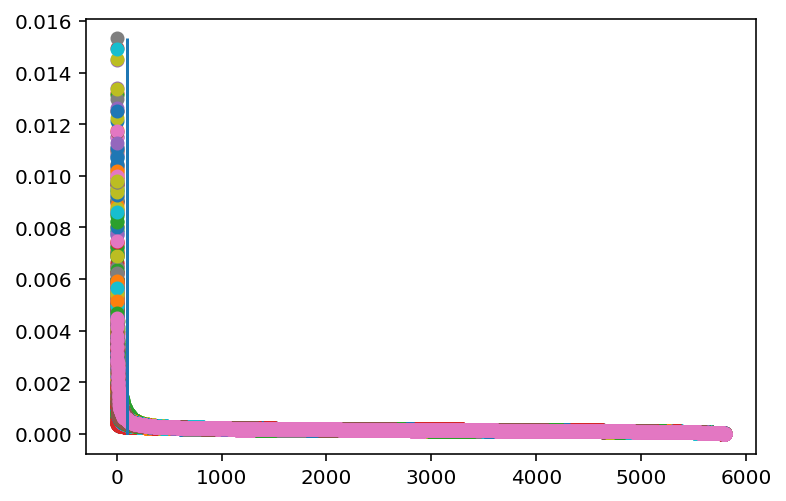

In [25]:
#Get single conds for first and secnd conds
all_gs_forinf = []
for g in range(len(first)):
    g1 = first[g]
    g2 = secnd[g]
    
    g1_nms = [f for f in filt_ids if (g1 in f and 'Neg' in f)]
    g2_nms = [f for f in filt_ids if (g2 in f and 'Neg' in f)]
    
    print(g)
    
    #sub U and S matrices
    bars1 = list(meta.cell_barcode[meta.guide_identity.isin(g1_nms)])
    bars2 = list(meta.cell_barcode[meta.guide_identity.isin(g2_nms)])
    
    if len(bars1) > 0 and len(bars2) > 0:
        S1 = S[np.isin(bars,bars1),:]
        S1 = S1[:,expr_filt]
        S2 = S[np.isin(bars,bars2),:]
        S2 = S2[:,expr_filt]

        X,Y = input_for_sel(S1,S2,ctrl_S)
        imp_genes = sel_genes(X,Y)

        all_gs_forinf += list(imp_genes)
    else:
        print('no cells for '+str(g))
    

    
    
    
    

In [26]:
all_gs_forinf = np.unique(all_gs_forinf)
len(all_gs_forinf)

1587

## **Set up Files for Inference and Select Cell Barcodes**

In [27]:
ks = [10,20] #K options for meK-Means
num_ks = len(ks) #Number of Ks to try

In [28]:
#Set  up output file names for inference run results

#Make names for each of the K runs
clus_names = ['k'+str(run_k) for run_k in ks]

#Output file names
dataset_names = ['meK_norman_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_norman_k10', 'meK_norman_k20']


In [29]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom']*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom']


Filter for barcodes in selected conditions + with UMI threshold

Dataset meK_norman_k10. 
	116844 barcodes in loom, 113389 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1CAGCATATCTCAACTT-2TCCCGATGTAAACGCG-5ATGAGGGCATTGGCGC-2TAGGCATCACA

110125 cells in annotations. 110125 in loom. 110107 pass filter.
Dataset meK_norman_k20. 
	116844 barcodes in loom, 113389 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1

110125 cells in annotations. 110125 in loom. 110107 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


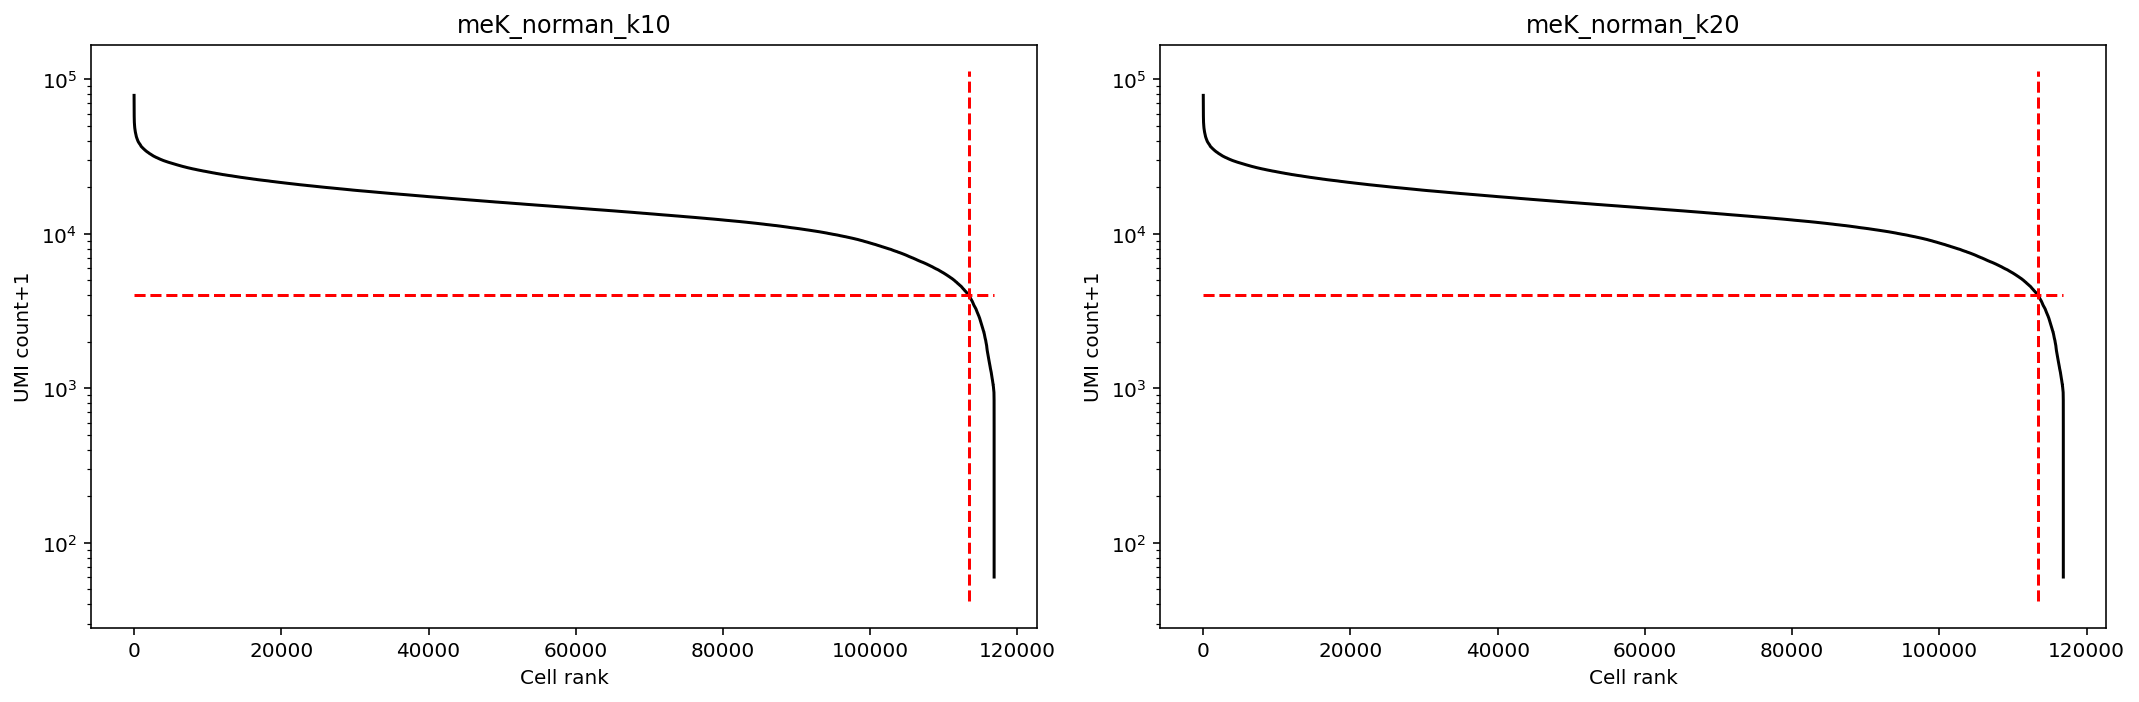

In [32]:
#Filter for cell barcodes with reasonable UMI threshold, and filter for cell types in 'chosen' list
cf = []
thr_lb = [4e3]*num_ks #Set UMI count filter for each K run

fig1,ax1 = plt.subplots(1,num_ks,figsize=(15,5))

for k in range(num_ks):
    filename = loom_filepaths[k]
    dataset_name = dataset_names[k]

    with lp.connect(filename,mode='r') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        bcs = ds.ca['barcode']
        n_cells = S.shape[1]
        #Make knee plot with S+U counts
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])

        #Make filter for low count barcodes
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

        #Select for barcodes in chosen list, if applicable
        annot_bcs = meta[(meta['guide_identity'].isin(filt_ids))]['cell_barcode']
        cf.append(np.isin(bcs,annot_bcs) & cf_)
        print(f'{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


    ax1[k].set_title(dataset_name)

!mkdir ./figs
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_norman_meK.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Create Output Files and Run meK-Means**

In [33]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

In [34]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1 created.
INFO:root:Dataset: meK_norman_k10
INFO:root:110107 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5742 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10 created.
INFO:root:Dataset: meK_norman_k20
INFO:root:110107 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5742 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20 created.
INFO:root:Total of 200 genes selected.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/diagnostic_figures created.


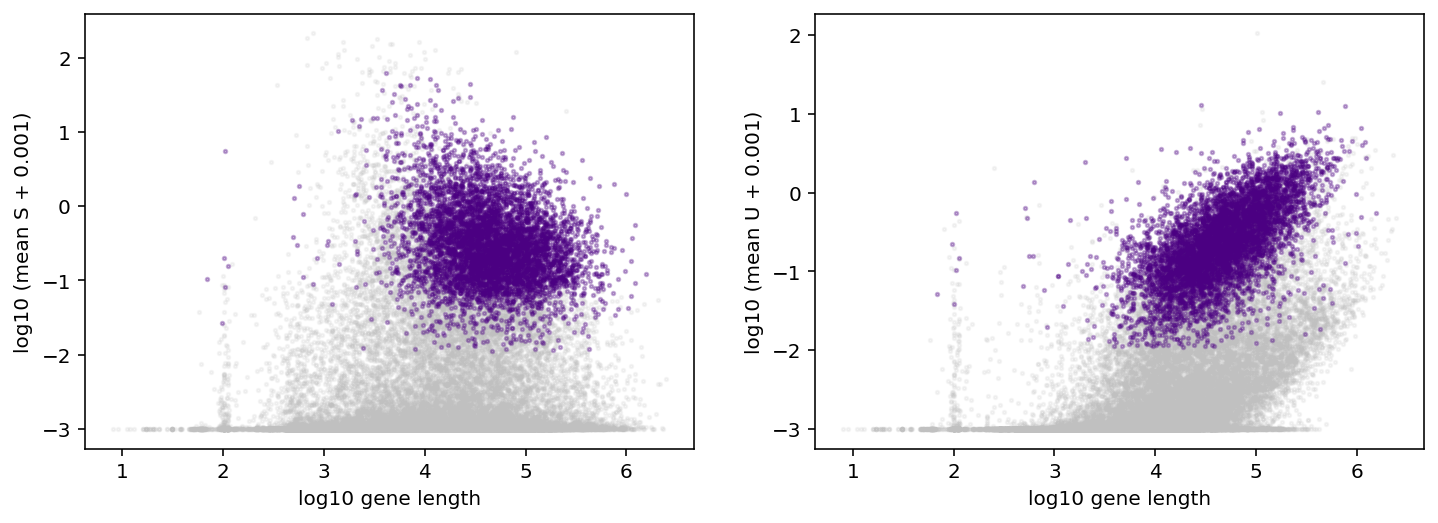

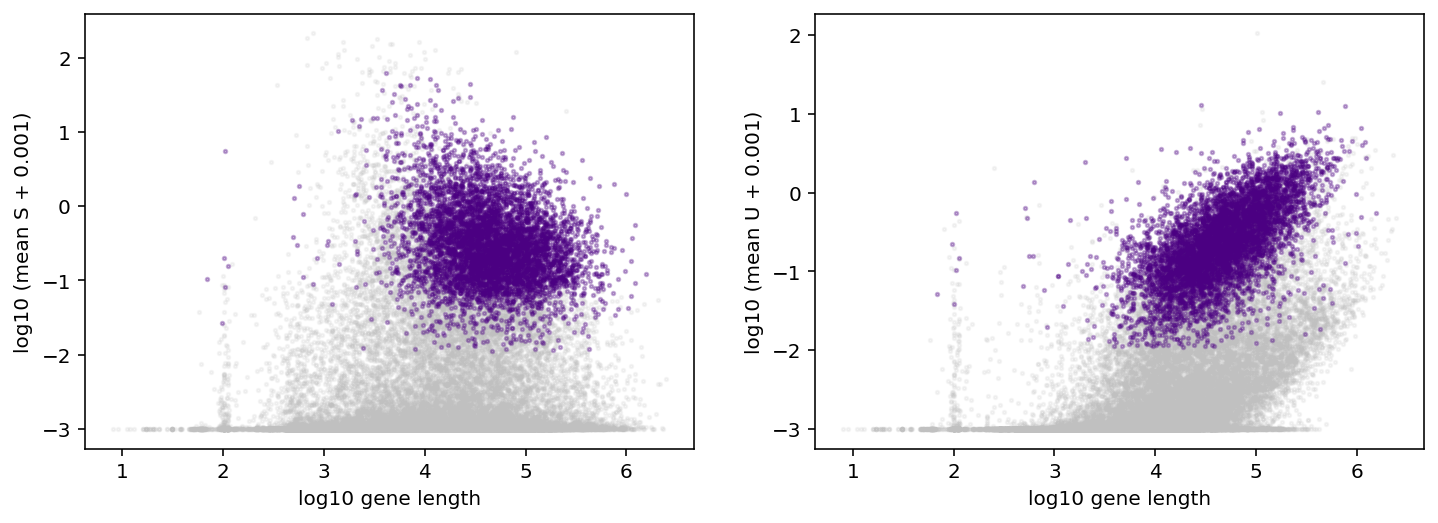

In [35]:
#Select to run inference on, same genes selected across all runs
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_norman',batch_id=1,\
                                             datestring='230917', n_genes=200,\
                                             exp_filter_threshold=None,cf=cf)

Save selected genes to genes.csv instead, for meK-Means

In [36]:
new_pd = pd.DataFrame(columns=range(len(all_gs_forinf)))
new_pd.loc[0] = all_gs_forinf
new_pd.to_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None,index=None)
new_pd.head()

0     1      2     3      4       5      6      7      8      9     ...  \
0  AAAS  AAK1  AAMDC  AATF  ABCA3  ABCB10  ABCB6  ABCB8  ABCC3  ABCC4  ...   

     1577    1578    1579    1580    1581    1582    1583   1584   1585  \
0  ZNF33A  ZNF358  ZNF544  ZNF564  ZNF595  ZNF611  ZNF706  ZNRD1  ZRSR2   

          1586  
0  ZSCAN16-AS1  

[1 rows x 1587 columns]

**Run meK-Means**

In [37]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]


samp_lb = [-7.157894736842105, -1.525]
samp_ub = [-7.157894736842105, -1.525]

gridsize = [1,1]

In [38]:
#Set number of epochs
epochs = 20

In [39]:
result_strings = []
for i in range(num_ks):

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)


INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k10
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230917_025_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07889397 0.07180132 0.07549823 0.17758262 0.09625919 0.12119237
 0.05855878 0.21349061 0.08467431 0.0220486 ]
Q Function:  -35067768.59708323

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.78968602e-03 5.97936108e-04 3.57301368e-03 3.35910159e-01
 2.36814424e-01 1.21665197e-01 5.67333833e-05 2.82586403e-01
 9.00644745e-03 3.07594528e-11]
Q Function:  -34829852.93805433

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.69497737e-08 9.08228616e-12 9.08272106e-12 3.10414050e-01
 3.23424450e-01 1.21794898e-01 9.08207471e-12 2.44366524e-01
 9.08236939e-12 9.08207515e-12]
Q Function:  -34471799.30788111

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.02160264e-11 9.08207471e-12 9.08207471e-12 3.19736902e-01
 3.32714133e-01 1.22009626e-01 9.08207471e-12 2.25539339e-01
 9.08207471e-12 9.08207564e-12]
Q Function:  -34437104.35743738

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.62s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08226722e-12 9.08207471e-12 9.08207471e-12 3.15937493e-01
 3.57970527e-01 1.26934285e-01 9.08207471e-12 1.99157694e-01
 9.08207471e-12 9.08207815e-12]
Q Function:  -34385831.92833631

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08222229e-12 9.08207471e-12 9.08207471e-12 3.20327871e-01
 3.61829018e-01 1.29745892e-01 9.08207471e-12 1.88097219e-01
 9.08207471e-12 9.08207746e-12]
Q Function:  -34359547.69437606

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08227496e-12 9.08207471e-12 9.08207471e-12 3.32322243e-01
 3.61403135e-01 1.31723524e-01 9.08207471e-12 1.74551098e-01
 9.08207471e-12 9.08207498e-12]
Q Function:  -34381398.37615654

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08222862e-12 9.08207471e-12 9.08207471e-12 3.35423700e-01
 3.62376502e-01 1.33899084e-01 9.08207471e-12 1.68300714e-01
 9.08207471e-12 9.08207626e-12]
Q Function:  -34355973.94393652

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08230438e-12 9.08207471e-12 9.08207471e-12 3.51227813e-01
 3.44623103e-01 1.34750865e-01 9.08207471e-12 1.69398219e-01
 9.08207471e-12 9.08207488e-12]
Q Function:  -34360405.443689585

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08225935e-12 9.08207471e-12 9.08207471e-12 3.53149184e-01
 3.46973036e-01 1.35874584e-01 9.08207471e-12 1.64003196e-01
 9.08207471e-12 9.08207489e-12]
Q Function:  -34348193.14099734

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08238468e-12 9.08207471e-12 9.08207471e-12 3.61078684e-01
 3.41759857e-01 1.38169132e-01 9.08207471e-12 1.58992327e-01
 9.08207471e-12 9.08207605e-12]
Q Function:  -34353122.78362529

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08225894e-12 9.08207471e-12 9.08207471e-12 3.70470110e-01
 3.32410117e-01 1.40935008e-01 9.08207471e-12 1.56184764e-01
 9.08207471e-12 9.08207479e-12]
Q Function:  -34356658.64134534

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08283351e-12 9.08207471e-12 9.08207471e-12 3.83550356e-01
 3.13263644e-01 1.43364758e-01 9.08207471e-12 1.59821243e-01
 9.08207471e-12 9.08207482e-12]
Q Function:  -34374827.30397356

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08253295e-12 9.08207471e-12 9.08207471e-12 3.80979321e-01
 3.17301277e-01 1.46855251e-01 9.08207471e-12 1.54864150e-01
 9.08207471e-12 9.08207506e-12]
Q Function:  -34353083.81594286

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08310789e-12 9.08207471e-12 9.08207471e-12 3.81751101e-01
 3.16282580e-01 1.48413781e-01 9.08207471e-12 1.53552538e-01
 9.08207471e-12 9.08207484e-12]
Q Function:  -34349415.401949495

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08312158e-12 9.08207471e-12 9.08207471e-12 3.72971952e-01
 3.29256425e-01 1.49646090e-01 9.08207471e-12 1.48125533e-01
 9.08207471e-12 9.08207479e-12]
Q Function:  -34346386.41335099

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.55s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08300890e-12 9.08207471e-12 9.08207471e-12 3.77427019e-01
 3.25143348e-01 1.49770595e-01 9.08207471e-12 1.47659037e-01
 9.08207471e-12 9.08207481e-12]
Q Function:  -34355435.170534685

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08294731e-12 9.08207471e-12 9.08207471e-12 3.67938856e-01
 3.37739373e-01 1.50349644e-01 9.08207471e-12 1.43972127e-01
 9.08207471e-12 9.08207488e-12]
Q Function:  -34349375.25794048

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08293367e-12 9.08207471e-12 9.08207471e-12 3.81419032e-01
 3.16475144e-01 1.52819335e-01 9.08207471e-12 1.49286489e-01
 9.08207471e-12 9.08207478e-12]
Q Function:  -34387992.8759144

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08332922e-12 9.08207471e-12 9.08207471e-12 3.74547484e-01
 3.18939561e-01 1.55900118e-01 9.08207471e-12 1.50612837e-01
 9.08207471e-12 9.08207481e-12]
Q Function:  -34369364.04614258

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/analysis_figures_3 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/analysis_figures_4 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/analysis_figures_5 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/analysis_figures_7 created.
INFO:root:Runtime: 920.4 seconds.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Pois

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01795848 0.00521998 0.06031652 0.00679495 0.14082078 0.12985126
 0.06974045 0.03728176 0.04693123 0.05862752 0.04813016 0.03004891
 0.03492334 0.04557837 0.04254863 0.04276865 0.03578704 0.03195113
 0.10439479 0.01032602]
Q Function:  -35570751.68515638

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.24s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.13420012e-12 2.05935382e-03 1.97590239e-09 4.15307139e-06
 1.22144038e-02 2.40357071e-01 1.96028711e-01 1.59497884e-09
 6.41178464e-06 6.35292008e-04 3.66056003e-03 2.11546463e-06
 1.42275153e-01 1.58394055e-07 2.33860807e-03 1.21512104e-10
 9.87640092e-06 9.46039351e-12 4.00408128e-01 9.08215861e-12]
Q Function:  -34983961.20350558

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.27s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207476e-12 9.08207473e-12 4.14206115e-11
 2.77392265e-09 2.01377074e-01 1.79871025e-01 9.08274763e-12
 9.08207471e-12 9.08207778e-12 1.87756762e-05 1.29916935e-09
 3.03102383e-01 9.35625911e-12 1.15132883e-10 9.08207513e-12
 9.08207471e-12 9.08207471e-12 3.15630738e-01 9.08207471e-12]
Q Function:  -34597392.47476424

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08467424e-12
 9.52387322e-12 1.66052717e-01 2.69742537e-01 9.08207509e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.36863325e-12
 2.58672635e-01 9.08213895e-12 9.08208865e-12 9.08207475e-12
 9.08207471e-12 9.08207472e-12 3.05532111e-01 9.08207471e-12]
Q Function:  -34540731.80540935

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08209441e-12
 9.08207509e-12 1.46503604e-01 2.74491063e-01 9.08207786e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.09953692e-12
 3.29338344e-01 9.08285291e-12 9.08207845e-12 9.08207471e-12
 9.08207471e-12 9.08207472e-12 2.49666989e-01 9.08207471e-12]
Q Function:  -34430571.11726301

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08209758e-12
 9.08207576e-12 1.38664326e-01 3.06243609e-01 9.08207649e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08531486e-12
 3.34612868e-01 9.08216826e-12 9.08208753e-12 9.08207473e-12
 9.08207471e-12 9.08207478e-12 2.20479197e-01 9.08207471e-12]
Q Function:  -34444056.172170505

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08209688e-12
 9.08209426e-12 1.36870586e-01 3.79770286e-01 9.08207814e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08365203e-12
 2.51677516e-01 9.08213965e-12 9.08208277e-12 9.08207505e-12
 9.08207471e-12 9.08207473e-12 2.31681612e-01 9.08207471e-12]
Q Function:  -34500143.8463142

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208610e-12
 9.08207721e-12 1.42148642e-01 3.51106749e-01 9.08207702e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08394923e-12
 3.12189199e-01 9.08216073e-12 9.08208808e-12 9.08207472e-12
 9.08207471e-12 9.08207472e-12 1.94555410e-01 9.08207471e-12]
Q Function:  -34357736.669010215

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208000e-12
 9.08207522e-12 1.44118834e-01 3.45840997e-01 9.08208018e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08680261e-12
 3.38526119e-01 9.08225718e-12 9.08208362e-12 9.08207472e-12
 9.08207471e-12 9.08207471e-12 1.71514051e-01 9.08207471e-12]
Q Function:  -34390147.32704992

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.70s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208496e-12
 9.08207572e-12 1.45554204e-01 3.43097884e-01 9.08207591e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08260895e-12
 3.53419436e-01 9.08211175e-12 9.08207709e-12 9.08207471e-12
 9.08207471e-12 9.08207471e-12 1.57928475e-01 9.08207471e-12]
Q Function:  -34374983.78010659

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.58s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208169e-12
 9.08207684e-12 1.46791377e-01 3.44247151e-01 9.08208563e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.09194291e-12
 3.57383958e-01 9.08241019e-12 9.08208298e-12 9.08207471e-12
 9.08207471e-12 9.08207472e-12 1.51577514e-01 9.08207471e-12]
Q Function:  -34374486.39123076

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208330e-12
 9.08209897e-12 1.45615886e-01 3.47554124e-01 9.08207661e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08311287e-12
 3.54766464e-01 9.08212062e-12 9.08208096e-12 9.08207471e-12
 9.08207471e-12 9.08207471e-12 1.52063525e-01 9.08207471e-12]
Q Function:  -34344230.175629124

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207884e-12
 9.08209409e-12 1.43780007e-01 3.78239223e-01 9.08207567e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08286178e-12
 3.21584225e-01 9.08211710e-12 9.08208063e-12 9.08207471e-12
 9.08207471e-12 9.08207471e-12 1.56396545e-01 9.08207471e-12]
Q Function:  -34379391.697122686

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207994e-12
 9.08208196e-12 1.46704354e-01 3.88410921e-01 9.08207657e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08650543e-12
 3.08285138e-01 9.08220572e-12 9.08208145e-12 9.08207472e-12
 9.08207471e-12 9.08207471e-12 1.56599587e-01 9.08207471e-12]
Q Function:  -34391110.31586629

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207979e-12
 9.08207613e-12 1.49065787e-01 3.97009832e-01 9.08207557e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08257511e-12
 3.00066147e-01 9.08210187e-12 9.08207658e-12 9.08207471e-12
 9.08207471e-12 9.08207471e-12 1.53858234e-01 9.08207471e-12]
Q Function:  -34376648.55157295

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207914e-12
 9.08208123e-12 1.52703329e-01 3.98815349e-01 9.08207842e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08811693e-12
 2.92730032e-01 9.08226082e-12 9.08208286e-12 9.08207473e-12
 9.08207471e-12 9.08207472e-12 1.55751290e-01 9.08207471e-12]
Q Function:  -34373036.05666216

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208408e-12
 9.08208019e-12 1.57587301e-01 3.91631723e-01 9.08207542e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.09085495e-12
 2.96033576e-01 9.08218308e-12 9.08208104e-12 9.08207473e-12
 9.08207471e-12 9.08207471e-12 1.54747400e-01 9.08207471e-12]
Q Function:  -34399676.91437013

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.54s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207980e-12
 9.08207594e-12 1.58217600e-01 3.76887179e-01 9.08207586e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08300832e-12
 3.16849798e-01 9.08211200e-12 9.08207935e-12 9.08207471e-12
 9.08207471e-12 9.08207471e-12 1.48045423e-01 9.08207471e-12]
Q Function:  -34336447.45558107

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08208510e-12
 9.08207931e-12 1.57748719e-01 3.78467501e-01 9.08207557e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08696710e-12
 3.15680052e-01 9.08221285e-12 9.08207853e-12 9.08207473e-12
 9.08207471e-12 9.08207473e-12 1.48103728e-01 9.08207471e-12]
Q Function:  -34350538.066522785

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08207998e-12
 9.08208566e-12 1.55676315e-01 3.78467121e-01 9.08207574e-12
 9.08207471e-12 9.08207471e-12 9.08207471e-12 9.08902915e-12
 3.23243396e-01 9.08221072e-12 9.08207911e-12 9.08207472e-12
 9.08207471e-12 9.08207471e-12 1.42613168e-01 9.08207471e-12]
Q Function:  -34336991.77215014

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/analysis_figures_5 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/analysis_figures_6 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/analysis_figures_12 created.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/analysis_figures_18 created.
INFO:root:Runtime: 1118.4 seconds.


In [ ]:
#DOes more genes --> more clusters? Try doubling to top 200?